In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# 프로젝트 개요
- 강의명 : 2022년 K-디지털 직업훈련(Training) 사업 
- AI데=이터플랫폼을 활용한 빅데이터 분석전문가 과정
- 교과목명 : 빅데이터 분석 및 시각화, AI개발 기초, 인공지능 프로그래밍
- 프로젝트 주제 : Spaceship Titanic 데이터를 활용한 탑승유무 분류모형 개발
- 프로젝트 마감일 : 2022년 4월 12일 화요일
- 수강생명 : 김영재

# reference:https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide

In [2]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB


# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Step 1. 라이브러리 및 데이터 불러오기
- 본 프로젝트 수행을 위한 필수 라이브러리를 불러온다. 

In [3]:
# 데이터 가공 
import numpy as np 
import pandas as pd 

print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns 
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)

#데이터 전처리




numpy version: 1.20.3
pandas version: 1.3.5
matplotlib version: 3.5.1
seaborn version: 0.11.2


In [4]:
train_data = pd.read_csv("../input/spaceship-titanic/train.csv")
test_data = pd.read_csv("../input/spaceship-titanic/test.csv")
sample_submission = pd.read_csv("../input/spaceship-titanic/sample_submission.csv")

train_data.shape, test_data.shape, sample_submission.shape

((8693, 14), (4277, 13), (4277, 2))

# 컬럼별 결측치 퍼센트 확인하기

In [5]:
missing=pd.DataFrame(train_data.isnull().sum().sort_values(),columns=['sum_missing'])
missing['percetage_null']=missing['sum_missing']/train_data.shape[0]*100
missing

,sum_missing,percetage_null
PassengerId,0,0.000000
Transported,0,0.000000
Age,179,2.059128
RoomService,181,2.082135
Destination,182,2.093639
FoodCourt,183,2.105142
Spa,183,2.105142
VRDeck,188,2.162660
Cabin,199,2.289198
Name,200,2.300702


# 숫자로 되어있는 데이터들만 모아놓기

In [6]:
num_data=train_data.select_dtypes(include='number')
num_data

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0
8689,18.0,0.0,0.0,0.0,0.0,0.0
8690,26.0,0.0,0.0,1872.0,1.0,0.0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0


# nunique () unique 한 변수의 개수를 추출해주는 메소드

In [7]:
train_data.nunique()   # 변수들이 passenger id 처럼 의미없는 값으로 되어 있는지 알 수 있음

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

####  종속변수의 비율 확인하여 주기.

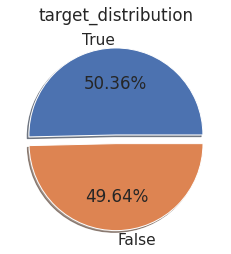

In [8]:
plt.figsize=(10,6)
plt.pie(train_data['Transported'].value_counts(),explode=[0,0.1],
       shadow=True,autopct='%.2f%%',labels=['True','False'])
plt.title("target_distribution")
plt.show()

- 언더샘플링이나 오버샘플링이 되어있지 않음

#### features 들을 분석하여보자

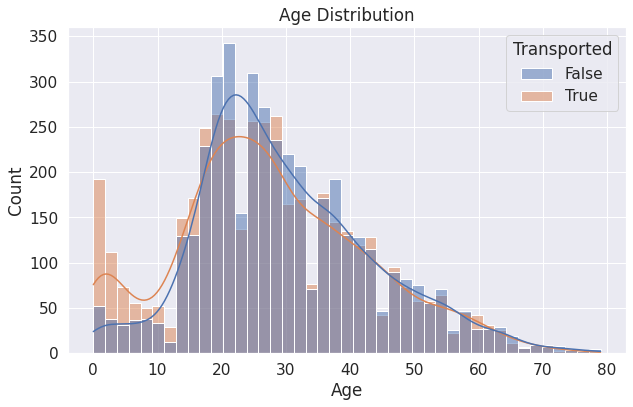

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(data=train_data,x='Age',hue='Transported',kde=True)
plt.title('Age Distribution')
plt.show()


- 0~18세 까지는 비행기에 탑승한 사람이 더 많다.  
- 18~25세 까지는 비행기에 탑승하지 못한 사람이 더 많다 
- 25세 이상은 그리 특별하진 않고 비슷 또는 동등하다

- 그리하여 0 ~ 18(child) , 18 ~ 25(adolecent) , 25~(adult) 로 새로운 변수를 만들어 줄 수 있게 된다.

### 비용 변수

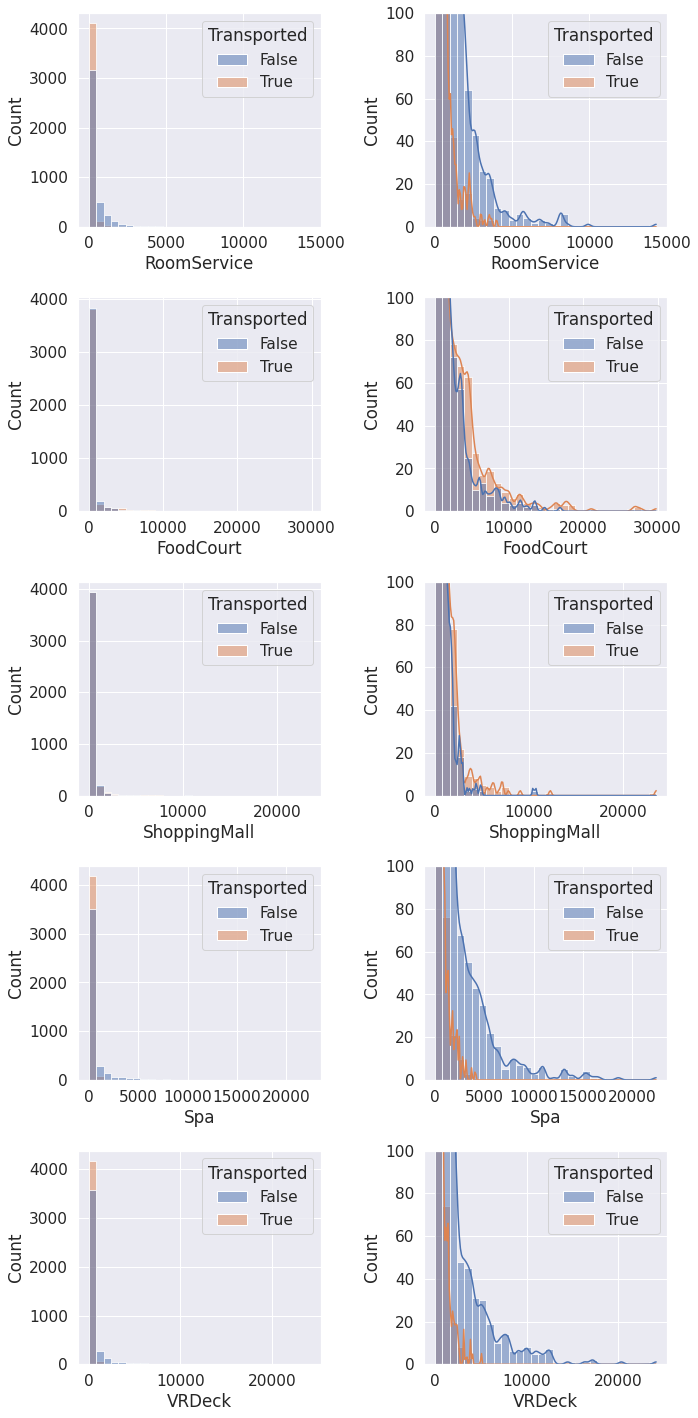

In [10]:
exp_features=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
luxury=['RoomService','Spa','VRDeck']
normal=['FoodCourt','ShoppingMall']
fig = plt.figure(figsize = (10, 20))
for i, col in enumerate(exp_features):
    #왼쪽 그래프
    ax=fig.add_subplot(5,2,2*i+1) # 3번쨰 파라미터는 index 이다.
    sns.histplot(data=train_data,x=col,bins=30,hue='Transported',ax=ax)
    #오른쪽 그래프 
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train_data,x=col,bins=30,hue='Transported',kde=True,ax=ax)
    plt.ylim([0,100])  # count 의 범위를 낮춤으로써, 변화를 급격하게 보여준다
fig.tight_layout()
plt.show()

- 대부분의 사람들은 돈을 쓰지 않았다
- 탑승을 한 사람들은 대부분 돈을 적게썼다.
- roomservice,vrdeck,spa(팁승하지 못한 사람 많음)  vs shoppingmall,foodcourt(탑승한 사람 많음) -> 고가 부대시설을 즐긴 사람 vs 그렇지 않은 사람

- 5개 편의시설 전체에 총 지출을 추적하는 feature 생성가능
- 돈을 쓴 사람과 쓰지 않은 사람을 나누는 feature 생성가능

### 범주형 변수.


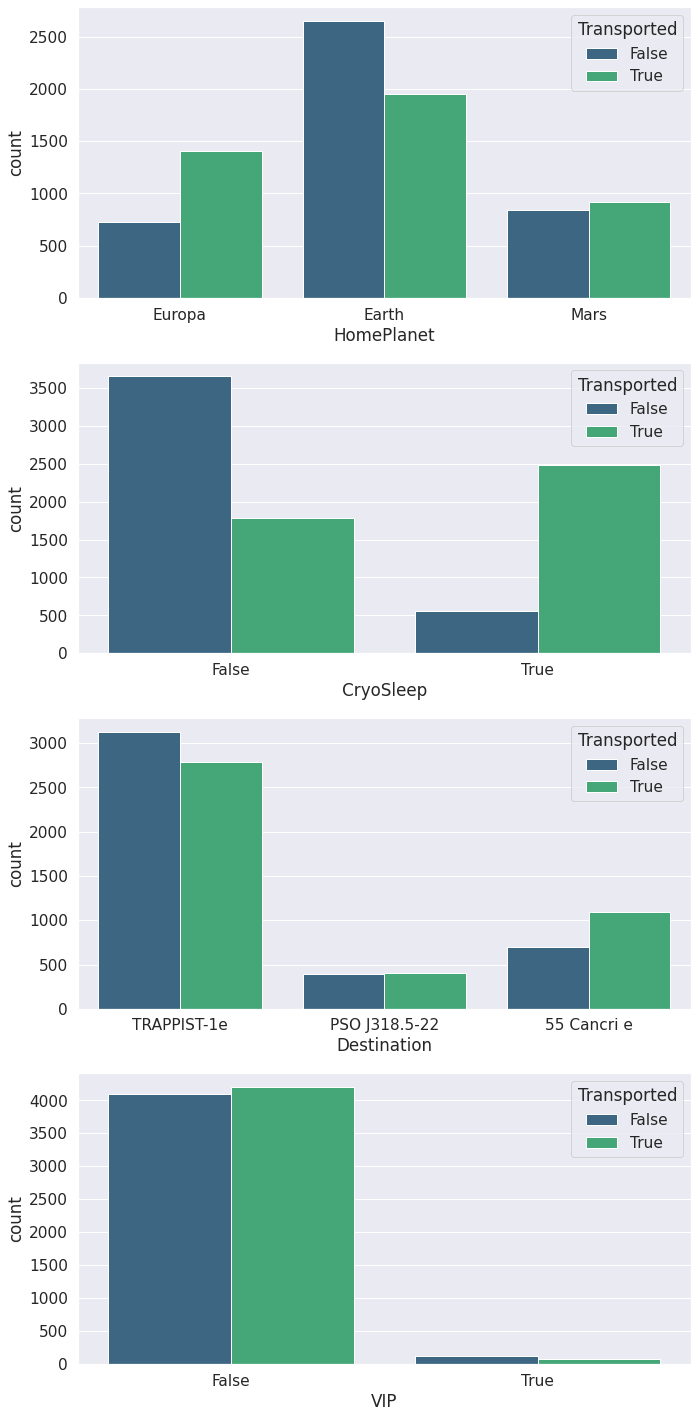

In [11]:
features=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
fig=plt.figure(figsize=(10,20))
for i,col in enumerate(features):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train_data,x=col,hue='Transported',ax=ax,palette='viridis')

fig.tight_layout()
plt.show()

- vip 변수는 transported true,false 비율이 비슷하기 떄문에 drop 시킨다
- cryosleep 변수가 대조적으로 굉장히 큰 차이를 준다.

# 결측치 관리

### age 결측치 제거
- 중앙값으로 결측치 제거

In [12]:
train_data['Age'].isnull().sum() # age의 결측치 179개

179

In [13]:

train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(train_data['Age'].median(), inplace=True) # 데이터누수가 일어나지 않게 , test_data 도 똑같이 !!
train_data['Age'].isnull().sum()
train_data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age               0
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

#### 질적변수

In [14]:
qual_features=['PassengerId', 'Cabin' ,'Name']
train_data[qual_features].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


- passengerid 는 111_00 형태로 이루어져 잇는데 앞 부분 111 은 함께 이동하는 그룹을 의미한다
 + 
- cabin의 형태는 갑판/번호/측면이며, 좌현에서는 p,우현에서는 s중 하나가 될 수 있습니다 
 + cabin 각각의 의미를 가지니까 갑판/번호/측면 으로 피쳐를 나누어주어 효율성을 높혀준다.

#### categorical data
- 결측치 처리 해주기 위해서, mode() 로 최빈값을 보여준다

In [15]:
train_data[['HomePlanet','CryoSleep','Destination','VIP']].mode()

,HomePlanet,CryoSleep,Destination,VIP
0,Earth,False,TRAPPIST-1e,False


- 결측치 값들은 최빈값으로 대체 시켜주는 전처리

In [16]:
train_data['HomePlanet'].fillna('Earth', inplace=True)
test_data['HomePlanet'].fillna('Earth', inplace=True)

train_data['CryoSleep'].fillna(False, inplace=True)
test_data['CryoSleep'].fillna(False, inplace=True)

train_data['Destination'].fillna('TRAPPIST-1e', inplace=True)
test_data['Destination'].fillna('TRAPPIST-1e', inplace=True)

train_data['VIP'].fillna(False, inplace=True)
test_data['VIP'].fillna(False, inplace=True)



In [17]:
print(train_data[exp_features].sum(axis=1))  #axis=1  !! 열 기준으로 합쳐주는 것!!
print(train_data[exp_features])
print(train_data[luxury])

0           0.0
1         736.0
2       10383.0
3        5176.0
4        1091.0
         ...   
8688     8536.0
8689        0.0
8690     1873.0
8691     4637.0
8692     4826.0
Length: 8693, dtype: float64
      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck
0             0.0        0.0           0.0     0.0     0.0
1           109.0        9.0          25.0   549.0    44.0
2            43.0     3576.0           0.0  6715.0    49.0
3             0.0     1283.0         371.0  3329.0   193.0
4           303.0       70.0         151.0   565.0     2.0
...           ...        ...           ...     ...     ...
8688          0.0     6819.0           0.0  1643.0    74.0
8689          0.0        0.0           0.0     0.0     0.0
8690          0.0        0.0        1872.0     1.0     0.0
8691          0.0     1049.0           0.0   353.0  3235.0
8692        126.0     4688.0           0.0     0.0    12.0

[8693 rows x 5 columns]
      RoomService     Spa  VRDeck
0             0.0     0.0   

## 파생변수

#### 아까  위에 말했던, 비용에 대한 값을 다 총합을 시켜주고 비용을 쓰지 않은 사람과 구분해 주고, 쓴 사람 중에서도, 비싼 어메니티를 이용한 사람과 평범한 어메니티를 이용한 사람의 차이가 확실 했으므로 , 둘을 LUXURY ,NORMAL 로 나누어준다


In [18]:
train_data['Expenditure']=train_data[exp_features].sum(axis=1)
test_data['Expenditure']=test_data[exp_features].sum(axis=1)

# 비용을 아예 쓰지 않은 사람 구분 해주고 모든 비용들을 합쳐준다


train_data['luxry_spend']=train_data[luxury].sum(axis=1)
train_data['normal_spend']=train_data[normal].sum(axis=1)


test_data['luxry_spend']=test_data[luxury].sum(axis=1)
test_data['normal_spend']=test_data[normal].sum(axis=1)


# 돈을 쓰지 않은 사람에게 True 를 반환하고, 이를 int 형으로 바꿔준다.  추후 머신러닝 돌려야 하기 때문에

print(train_data.head())



  PassengerId HomePlanet  CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa      False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth      False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa      False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa      False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth      False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  Expenditure  luxry_spend  normal_spend  
0        False          0.0          0.0 

In [19]:
train_data['No_spending']=(train_data['Expenditure']==0).astype(int)
test_data['No_spending']=(test_data['Expenditure']==0).astype(int)

In [20]:
# exp_features 에도, 최빈값인 0을 넣어줍니다
for col in exp_features:
    train_data.loc[train_data[col].isna(),col]=0
    test_data.loc[test_data[col].isna(),col]=0
train_data.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
Expenditure       0
luxry_spend       0
normal_spend      0
No_spending       0
dtype: int64

In [21]:
#
train_data['Cabin'].fillna('Z/9999/Z', inplace=True)
test_data['Cabin'].fillna('Z/9999/Z', inplace=True)

train_data['Name'].fillna('No Name', inplace=True)
test_data['Name'].fillna('No Name', inplace=True)

### 파생변수

- AGE 위에 시각화 했을때 처럼,  구간별로 나누어준다.

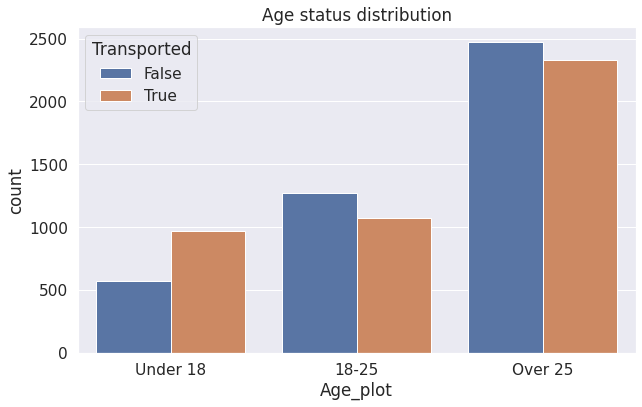

In [22]:
#위에서 언급했던 나이대별로 타겟값이 차이를 보이기때문에, 나이별로 묶어주어, 과적합 방지

train_data['Under_18']=(train_data['Age']<18).astype(int)
train_data['18_to_25']=((train_data['Age']>=18) & (train_data['Age']<=25)).astype(int)
train_data['Over_25']=(train_data['Age']>25).astype(int)

test_data['Under_18']=(test_data['Age']<18).astype(int)
test_data['18_to_25']=((test_data['Age']>=18) & (test_data['Age']<=25)).astype(int)
test_data['Over_25']=(test_data['Age']>25).astype(int)

train_data['Age_plot']=train_data['Under_18']+2*train_data['18_to_25']+3*train_data['Over_25']
plt.figure(figsize=(10, 6))
g=sns.countplot(data=train_data, x='Age_plot', hue='Transported')
plt.title('Age status distribution')
g.set_xticklabels(['Under 18', '18-25', 'Over 25'])
train_data.drop('Age_plot', axis=1, inplace=True)


#### 비용에대한 파생변수

- 비용을 지출한 사람은 비용의 총합이라는 feature 를 만들어주고
- 비용을 지출하지 않은사람들은 따로 떼어준다.

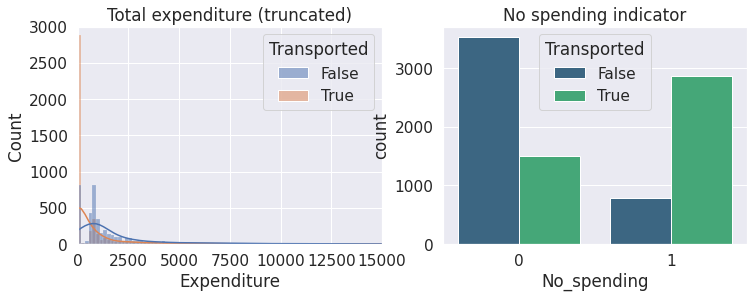

In [23]:





# Plot distribution of new features
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train_data, x='Expenditure', hue='Transported', kde = True, bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,3000])
plt.xlim([0,15000])

plt.subplot(1,2,2)
sns.countplot(data=train_data, x='No_spending', hue='Transported', palette = 'viridis')
plt.title('No spending indicator')
plt.show()

- 이 그래프에서도 확연히 볼 수 있듯이  비용을 안 쓴사람은 쓴 사람에 비해 탑승율이 더 높았다


In [24]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   bool   
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   bool   
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Expenditure   8693 non-null   float64
 15  luxry_spend   8693 non-null   float64
 16  normal_spend  8693 non-null   float64
 17  No_spending   8693 non-null   int64  
 18  Under_18      8693 non-null 

### passenger 는 그룹을 나타내 주기 때문에 그 룹을 나누어 준다. 

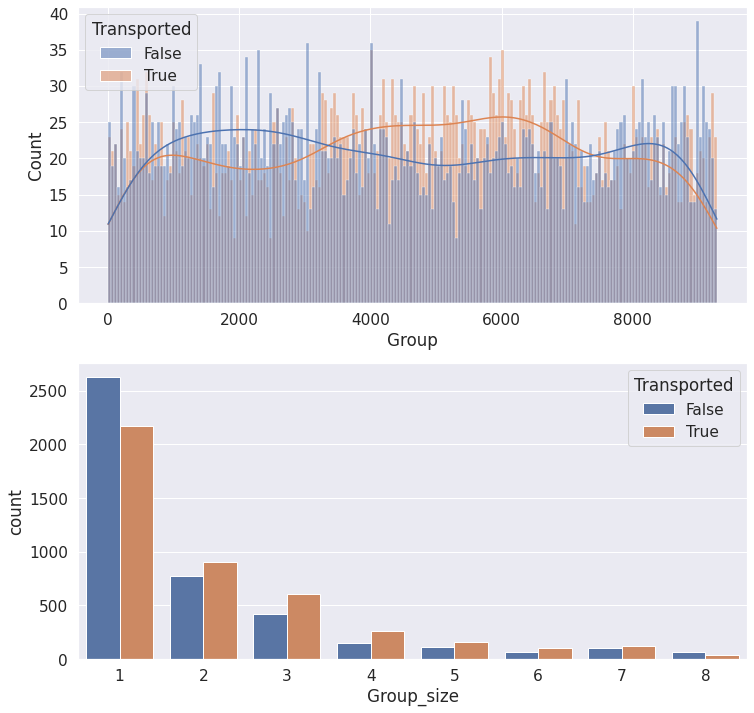

In [25]:
# New features - training set
train_data['Group'] = train_data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
train_data['Group_size']=train_data['Group'].map(lambda x: train_data['Group'].value_counts()[x])

# New features - test set
test_data['Group'] = test_data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test_data['Group_size']=test_data['Group'].map(lambda x: test_data['Group'].value_counts()[x])

# Plot distribution of new features
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.histplot(data=train_data, x='Group', hue='Transported', bins = 200, kde = True)

plt.subplot(2,1,2)
sns.countplot(data=train_data, x='Group_size', hue='Transported')
fig.tight_layout()
plt.show()

- 그룹 지표는 종류가 너무 많기 떄문에 인코딩 불가
- 반면 group_size 는 solo 로 온 사람을 색출 할 수 있기 떄문에 유용하다.

(0.0, 3000.0)

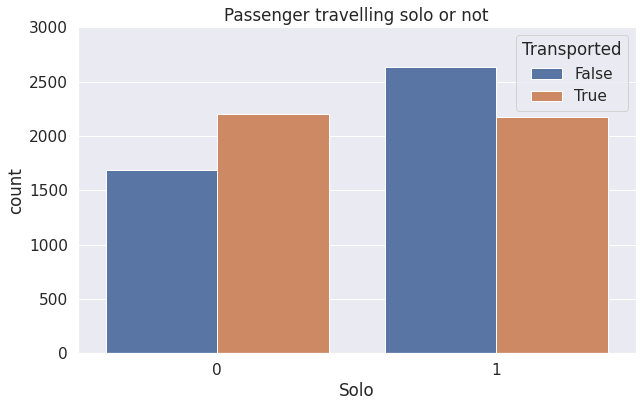

In [26]:
# New feature
train_data['Solo']=(train_data['Group_size']==1).astype(int)
test_data['Solo']=(test_data['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,6))
sns.countplot(data=train_data, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

- 그룹으로 가지 않은 사람들은 탑승했을가능성이 크고 , 솔로로 간 사람들은 탑승하지 못했을 가능성이 크다

#### cabin의 위치
-cabin deck 의 위치별로 true false 가 명확하게 구분되는 것을 볼 수 있다

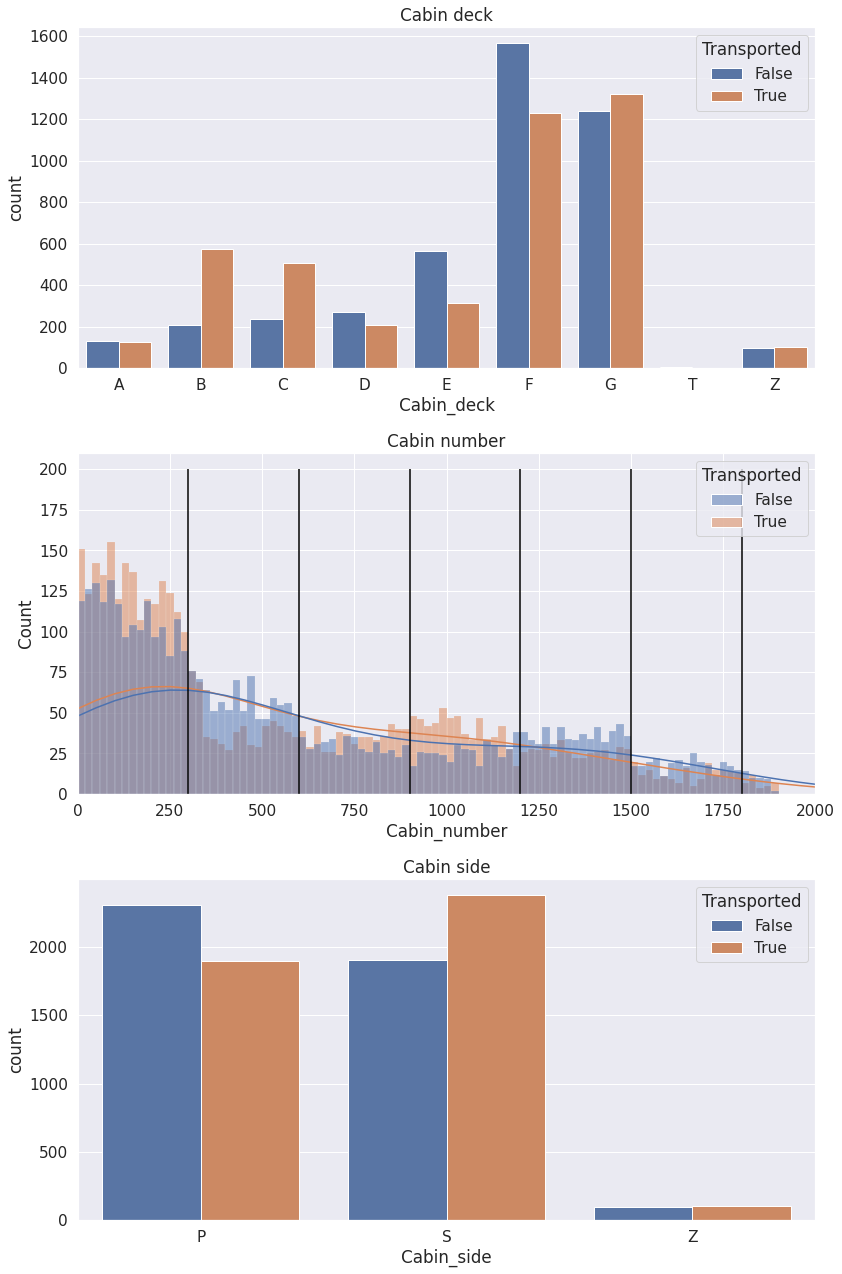

In [27]:
# New features - training set
train_data['Cabin_deck'] = train_data['Cabin'].apply(lambda x: x.split('/')[0])
train_data['Cabin_number'] = train_data['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train_data['Cabin_side'] = train_data['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test_data['Cabin_deck'] = test_data['Cabin'].apply(lambda x: x.split('/')[0])
test_data['Cabin_number'] = test_data['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test_data['Cabin_side'] = test_data['Cabin'].apply(lambda x: x.split('/')[2])

# Plot distribution of new features
fig=plt.figure(figsize=(12,18))
plt.subplot(3,1,1)
sns.countplot(data=train_data, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T','Z'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train_data, x='Cabin_number', hue='Transported',binwidth=20, kde = True)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train_data, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

- cabin number 를 보면 300개의 cabin 을 기준으로 그룹화 되는 것 을 확인 할 수 있다.

#### 위에서 얻은 인사이트로 cabin number 에 따라서 새로운 변수를 생성시켜 주어 보자 !!

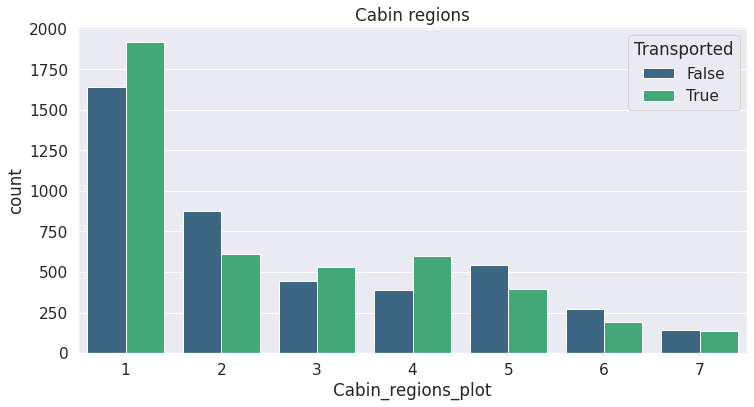

In [28]:


# New features - training set
train_data['Cabin_region1']=(train_data['Cabin_number']<300).astype(int)   # one-hot encoding
train_data['Cabin_region2']=((train_data['Cabin_number']>=300) & (train_data['Cabin_number']<600)).astype(int)
train_data['Cabin_region3']=((train_data['Cabin_number']>=600) & (train_data['Cabin_number']<900)).astype(int)
train_data['Cabin_region4']=((train_data['Cabin_number']>=900) & (train_data['Cabin_number']<1200)).astype(int)
train_data['Cabin_region5']=((train_data['Cabin_number']>=1200) & (train_data['Cabin_number']<1500)).astype(int)
train_data['Cabin_region6']=((train_data['Cabin_number']>=1500) & (train_data['Cabin_number']<1800)).astype(int)
train_data['Cabin_region7']=(train_data['Cabin_number']>=1800).astype(int)

# New features - test set
test_data['Cabin_region1']=(test_data['Cabin_number']<300).astype(int)   # one-hot encoding
test_data['Cabin_region2']=((test_data['Cabin_number']>=300) & (test_data['Cabin_number']<600)).astype(int)
test_data['Cabin_region3']=((test_data['Cabin_number']>=600) & (test_data['Cabin_number']<900)).astype(int)
test_data['Cabin_region4']=((test_data['Cabin_number']>=900) & (test_data['Cabin_number']<1200)).astype(int)
test_data['Cabin_region5']=((test_data['Cabin_number']>=1200) & (test_data['Cabin_number']<1500)).astype(int)
test_data['Cabin_region6']=((test_data['Cabin_number']>=1500) & (test_data['Cabin_number']<1800)).astype(int)
test_data['Cabin_region7']=(test_data['Cabin_number']>=1800).astype(int)

# Plot distribution of new features
plt.figure(figsize=(12,6))
train_data['Cabin_regions_plot']=(train_data['Cabin_region1']+2*train_data['Cabin_region2']+3*train_data['Cabin_region3']+4*train_data['Cabin_region4']+5*train_data['Cabin_region5']+6*train_data['Cabin_region6']+7*train_data['Cabin_region7']).astype(int)
sns.countplot(data=train_data, x='Cabin_regions_plot', hue='Transported', palette = 'viridis')
plt.title('Cabin regions')
train_data.drop('Cabin_regions_plot', axis=1, inplace=True)

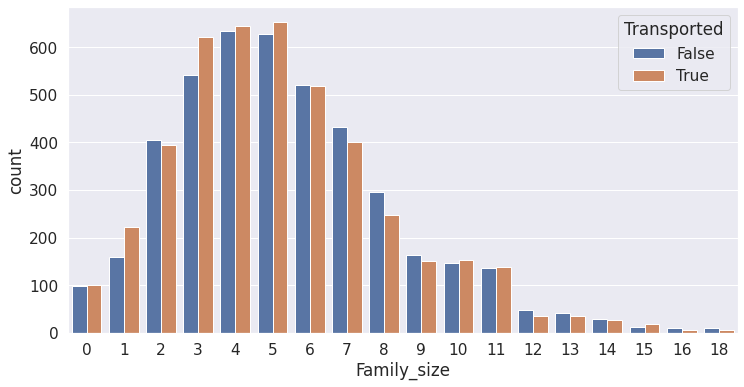

In [29]:
# New features - training set
train_data['Surname']=train_data['Name'].str.split().str[-1]
train_data['Family_size']=train_data['Surname'].map(lambda x: train_data['Surname'].value_counts()[x])

# New features - test set
test_data['Surname']=test_data['Name'].str.split().str[-1]
test_data['Family_size']=test_data['Surname'].map(lambda x: test_data['Surname'].value_counts()[x])

# Set outliers (no name) to have no family
train_data.loc[train_data['Family_size']==200,'Family_size']=0
test_data.loc[test_data['Family_size']==200,'Family_size']=0

# New feature distribution
plt.figure(figsize=(12,6))
sns.countplot(data=train_data, x='Family_size', hue='Transported')
plt.show()

### 불필요한 변수 제거

In [30]:
# Drop qualitative/redundant/high cardinality features
train_data.drop(['PassengerId', 'Cabin', 'Name', 'Surname', 'VIP', 'Group', 'Cabin_number','Expenditure'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Cabin', 'Name', 'Surname', 'VIP', 'Group', 'Cabin_number','Expenditure'], axis=1, inplace=True)

# Preview resulting training set
train_data.head()


,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,Cabin_deck,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,Europa,False,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,False,...,B,P,1,0,0,0,0,0,0,1
1,Earth,False,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,True,...,F,S,1,0,0,0,0,0,0,4
2,Europa,False,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,False,...,A,S,1,0,0,0,0,0,0,6
3,Europa,False,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,False,...,A,S,1,0,0,0,0,0,0,6
4,Earth,False,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,True,...,F,S,1,0,0,0,0,0,0,6


In [31]:
train_data=train_data.drop(['Spa','FoodCourt','FoodCourt','ShoppingMall','VRDeck'],axis=1)
test_data=test_data.drop(['Spa','FoodCourt','FoodCourt','ShoppingMall','VRDeck'],axis=1)

In [32]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8693 non-null   object 
 1   CryoSleep      8693 non-null   bool   
 2   Destination    8693 non-null   object 
 3   Age            8693 non-null   float64
 4   RoomService    8693 non-null   float64
 5   Transported    8693 non-null   bool   
 6   luxry_spend    8693 non-null   float64
 7   normal_spend   8693 non-null   float64
 8   No_spending    8693 non-null   int64  
 9   Under_18       8693 non-null   int64  
 10  18_to_25       8693 non-null   int64  
 11  Over_25        8693 non-null   int64  
 12  Group_size     8693 non-null   int64  
 13  Solo           8693 non-null   int64  
 14  Cabin_deck     8693 non-null   object 
 15  Cabin_side     8693 non-null   object 
 16  Cabin_region1  8693 non-null   int64  
 17  Cabin_region2  8693 non-null   int64  
 18  Cabin_re

In [33]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

HomePlanet       0
CryoSleep        0
Destination      0
Age              0
RoomService      0
Transported      0
luxry_spend      0
normal_spend     0
No_spending      0
Under_18         0
18_to_25         0
Over_25          0
Group_size       0
Solo             0
Cabin_deck       0
Cabin_side       0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0
Family_size      0
dtype: int64
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
RoomService      0
luxry_spend      0
normal_spend     0
No_spending      0
Under_18         0
18_to_25         0
Over_25          0
Group_size       0
Solo             0
Cabin_deck       0
Cabin_side       0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0
Family_size      0
dtype: int64


- 결측치 제거 완료

In [34]:
# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

Lables (정답) 생성

In [35]:
y=train_data['Transported'].copy().astype(int) # label생성 이것 또한 인코딩이 된 것
X=train_data.drop('Transported', axis=1).copy() # label 을 drop 시킨 데이터 생성
X_test_data=test_data.copy() # X_test_data 에는  test_data 를 copy 해준다
X_test_data.shape
print(X.shape)
X_test_data.head(40)




(8693, 23)


,HomePlanet,CryoSleep,Destination,Age,RoomService,luxry_spend,normal_spend,No_spending,Under_18,18_to_25,...,Cabin_deck,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,Earth,True,TRAPPIST-1e,27.0,0.0,0.0,0.0,1,0,0,...,G,S,1,0,0,0,0,0,0,4
1,Earth,False,TRAPPIST-1e,19.0,0.0,2823.0,9.0,0,0,1,...,F,S,1,0,0,0,0,0,0,1
2,Europa,True,55 Cancri e,31.0,0.0,0.0,0.0,1,0,0,...,C,S,1,0,0,0,0,0,0,1
3,Europa,False,TRAPPIST-1e,38.0,0.0,766.0,6652.0,0,0,0,...,C,S,1,0,0,0,0,0,0,1
4,Earth,False,TRAPPIST-1e,20.0,10.0,10.0,635.0,0,0,1,...,F,S,1,0,0,0,0,0,0,3
5,Earth,False,TRAPPIST-1e,31.0,0.0,173.0,1878.0,0,0,0,...,F,P,1,0,0,0,0,0,0,4
6,Europa,True,55 Cancri e,21.0,0.0,0.0,0.0,1,0,1,...,B,P,1,0,0,0,0,0,0,1
7,Europa,True,TRAPPIST-1e,20.0,0.0,0.0,0.0,1,0,1,...,D,S,1,0,0,0,0,0,0,2
8,Europa,True,55 Cancri e,23.0,0.0,0.0,0.0,1,0,1,...,D,S,1,0,0,0,0,0,0,2
9,Earth,False,55 Cancri e,24.0,0.0,0.0,639.0,0,0,1,...,F,S,1,0,0,0,0,0,0,2


### 범주형 변수 인코딩과 스케일링


In [36]:
cat_col=['HomePlanet','CryoSleep','Destination','Cabin_deck','Cabin_side']
pre=train_data[cat_col]

pre_enc=pd.get_dummies(pre)

pre_enc['CryoSleep']=pre_enc['CryoSleep'].map({True:1,False:0})

print(pre_enc.shape)

(8693, 19)


In [37]:

cat_col=['HomePlanet','CryoSleep','Destination','Cabin_deck','Cabin_side']
pre1=test_data[cat_col]

pre_enc1=pd.get_dummies(pre1)

pre_enc1['CryoSleep']=pre_enc1['CryoSleep'].map({True:1,False:0})

print(pre_enc1.shape)




(4277, 19)


In [38]:
print(X.shape)
print(X_test_data.shape)
X.info()
X=X.drop(['HomePlanet','CryoSleep','Destination','Cabin_deck','Cabin_side'],axis=1)
X_test_data=X_test_data.drop(['HomePlanet','CryoSleep','Destination','Cabin_deck','Cabin_side'],axis=1)


(8693, 23)
(4277, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8693 non-null   object 
 1   CryoSleep      8693 non-null   bool   
 2   Destination    8693 non-null   object 
 3   Age            8693 non-null   float64
 4   RoomService    8693 non-null   float64
 5   luxry_spend    8693 non-null   float64
 6   normal_spend   8693 non-null   float64
 7   No_spending    8693 non-null   int64  
 8   Under_18       8693 non-null   int64  
 9   18_to_25       8693 non-null   int64  
 10  Over_25        8693 non-null   int64  
 11  Group_size     8693 non-null   int64  
 12  Solo           8693 non-null   int64  
 13  Cabin_deck     8693 non-null   object 
 14  Cabin_side     8693 non-null   object 
 15  Cabin_region1  8693 non-null   int64  
 16  Cabin_region2  8693 non-null   int64  
 17  Cabin_region3  8693 non-null  

In [39]:
print(X.shape)
print(X_test_data.shape)
print(pre_enc.shape)
print(pre_enc1.shape)
X=pd.concat([X,pre_enc],axis=1)
X_test_data=pd.concat([X_test_data,pre_enc1],axis=1)

(8693, 18)
(4277, 18)
(8693, 19)
(4277, 19)


In [40]:
print(X.shape)
print(X_test_data.shape)


(8693, 37)
(4277, 37)


# Step 4. 머신러닝 모형 개발
- 모형에 대한 설명 필요
- 모형을 1-2개 사용
- 교차 검증
- 하이퍼파라미터 튜닝

### 검증데이터를 만들어 준다. 

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6085, 37), (2608, 37), (6085,), (2608,))

- 이번에는 LightGBM 클래스를 부른 후 모형을 학습한다. 

# 하이퍼파라미터 튜닝
- 랜덤서치 (매개변수, max_depth) / 0.796
- 그리드서치 / 0.791

In [42]:
from lightgbm import LGBMClassifier


lgb = LGBMClassifier(random_state=42,n_estimators=150,max_depth=4,)
lgb

LGBMClassifier(max_depth=4, n_estimators=150, random_state=42)

# Step 5. 모형 평가
- 훈련데이터 쪼갠다. 훈련데이터 + 검증데이터 분리
- 정확도 비교
- 혼동행렬 (Confusion Matrix) 설명

- 먼저 cross_validate() 활용한다. 

In [43]:

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)
scores = cross_validate(lgb, X_train, y_train, return_train_score = True, cv=splitter)

print("train Acc.", np.mean(scores['train_score']))
print("test Acc.", np.mean(scores['test_score']))

train Acc. 0.8624897288414133
test Acc. 0.8131470829909613


- 이번에는 검증 데이터를 활용하여 정확도를 예상해본다. 

In [44]:

from sklearn.metrics import accuracy_score

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)
print("Acc.", accuracy_score(y_val, y_pred))

## confusion matrix





Acc. 0.7979294478527608


# Step 6. 제출
- 제출 양식은 샘플 만들어드림

In [45]:
test_preds = lgb.predict(X_test_data.to_numpy())
sample_submission['Transported'] = test_preds.astype("bool")
sample_submission.to_csv("submission.csv",index=False)
sample_submission.head()

print(test_preds.shape)
print(X_val.shape)
print(X_test_data.shape)



(4277,)
(2608, 37)
(4277, 37)


# 혼동행렬

[[1007  282]
 [ 245 1074]]


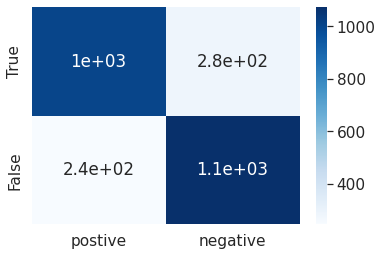

In [46]:
import sklearn.metrics as metrics

cm=metrics.confusion_matrix(y_val,y_pred)
print(cm)


sns.heatmap(cm, annot=True, cmap='Blues',
           xticklabels=['postive', 'negative'],       # 예측
           yticklabels=['True', 'False'])               # 실제
plt.show()




# 정밀도
- 'True' 으로 예측했을때 실제도 'True' 인 비율

In [47]:
# 72/(72+1)
p = metrics.precision_score(y_val, y_pred)
p




0.7920353982300885

# 재현율
- 실제로 True 를 True 로 예측한 비율

In [48]:
r = metrics.recall_score(y_val, y_pred)
r


0.8142532221379833

# F1 score 
- 정밀도와 재현율의 조화평균

In [49]:
metrics.f1_score(y_val, y_pred)



0.8029906542056076

# 곡선하 면정, 민감도 또는 1- 특이성 그래프 

- 참 긍정율과 거짓 부정률 사이를 표현하기 위해 사용

<AxesSubplot:xlabel='FPR', ylabel='TPR'>

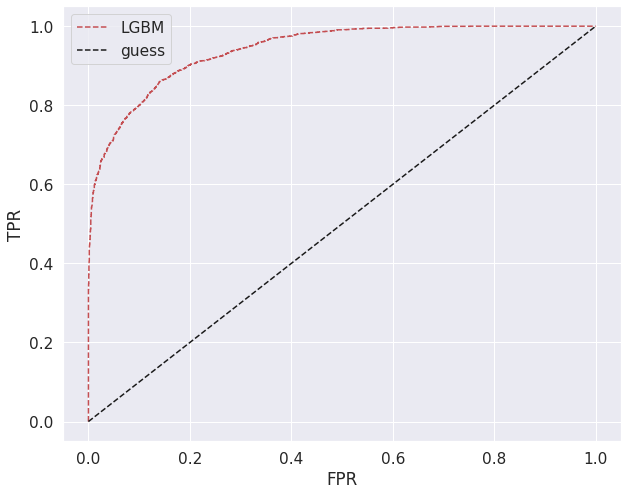

In [50]:
proba=lgb.predict_proba(X_train)
fig,ax=plt.subplots(figsize=(10,8))
fpr, tpr, thressholds = metrics.roc_curve(y_train, proba[:,1])
ax.plot(fpr,tpr,'r--',label='LGBM')
ax.plot([0, 1],[0, 1], 'k--', label='guess')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend()
ax








